In [2]:
import os
import pickle as pkl

# import numpy as np
# import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import image_dataset_from_directory
from keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
# print(f"Pandas {pd.__version__}")

Tensor Flow Version: 2.6.2
Keras Version: 2.6.0


In [8]:
DATA_FOLDER = "../input/hindi-mnist-data"
TRAIN_FOLDER_NAME = "Train"
TEST_FOLDER_NAME = "Test"
DEVANAGARI_DATA_FOLDER = os.path.join(DATA_FOLDER, "DevanagariHandwrittenDigitDataset")
print(DEVANAGARI_DATA_FOLDER)

../input/hindi-mnist-data/DevanagariHandwrittenDigitDataset


In [4]:
labels_to_keep = [
    "digit_0", "digit_1", "digit_2", "digit_3", "digit_4", "digit_5", "digit_6", "digit_7", "digit_8", "digit_9"
]

### Dataset and Model Parameters

In [9]:
RANDOM_SEED = 42

# Data parameters
IMG_HEIGHT = 32
IMG_WIDTH = 32
VALIDATION_SPLIT = 0.1

# Model parameters
BATCH_SIZE = 32
KERNEL_SIZE = (3, 3)
MAX_POOLING_SIZE = (2, 2)
DROPOUT = 0.5

num_classes = len(labels_to_keep)

In [10]:
classes = labels_to_keep
classes_to_output_class_names = {
    "digit_0": "0", "digit_1": "1", "digit_2": "2", "digit_3": "3", "digit_4": "4", "digit_5": "5", "digit_6": "6",
    "digit_7": "7", "digit_8": "8", "digit_9": "9"
}


print("Gathering training dataset...")
train_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering validation dataset...")
val_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering test dataset...")
test_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TEST_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=None,  # None, so that we get all the data.
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Gathering training dataset...
Found 17000 files belonging to 10 classes.
Using 15300 files for training.


2022-02-24 07:44:43.508323: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Gathering validation dataset...
Found 17000 files belonging to 10 classes.
Using 1700 files for validation.
Gathering test dataset...
Found 3000 files belonging to 10 classes.


In [11]:
train_dataset.element_spec

(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [12]:
class_names_to_labels = dict([(cls_name, lbl) for cls_name, lbl in zip(classes, list(range(len(classes))))])
# print(class_names_to_labels)
labels_to_class_names = dict([(v, k) for k, v in class_names_to_labels.items()])
print(labels_to_class_names)

{0: 'digit_0', 1: 'digit_1', 2: 'digit_2', 3: 'digit_3', 4: 'digit_4', 5: 'digit_5', 6: 'digit_6', 7: 'digit_7', 8: 'digit_8', 9: 'digit_9'}


### Look at the data
Let us take a look at the data after it has been stored as a tensorflow tf.Data.Dataset object.

2022-02-24 07:45:10.175518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 32, 1)


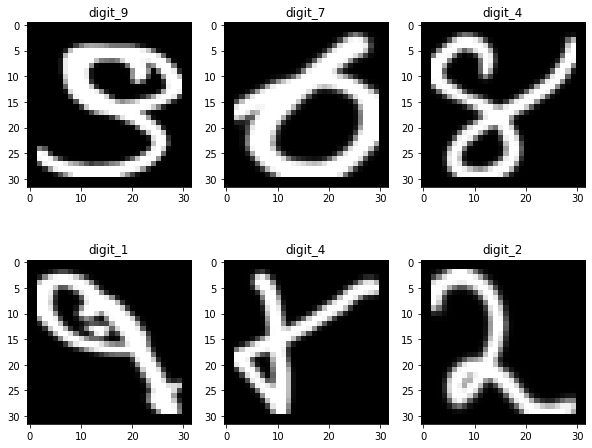

In [13]:
# Take a look at the input data
rows = 2
columns = 3
fig = plt.figure(figsize=(10, 8))
j = 1
for images, labels in train_dataset.take(1):
    print(images[0].shape)
    for i, l in zip(images[:6], labels[:6]):
        fig.add_subplot(rows, columns, j)
        plt.imshow(tf.squeeze(i), cmap='gray', vmin=0, vmax=255)
        plt.title(labels_to_class_names[int(l)])
        j += 1

### Data Augmentation and Normalisation
#### Normalisation

The values of pixels in the images range from `[0, 255]`.

We should normalize the values to be in the `[0, 1]` range.

The purpose of Normalisation is to make values measured on different scales to be all "squished" or "expanded" to a common scale/range such as `[0, 1]`.
This ensures that each variable in the data is given an equal importance and no variable influences the model parameters more than any other purely because it's values are larger.

We will perform the normalization using <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling"><code>tf.keras.layers.Rescaling</code></a>.

#### Augmentation
Augmenting the data allows us to ensure that the model doesn't just learn something that's common for the entire class, but has no meaning when it comes to classification.

For example, consider a dataset with blue cars and red cars.

If all the blue cars are facing to the right and all red cars are facing left, then the model will end up being influenced by the orientation of the car in the image, thus producing incorrect predications when you ask the model to predict, say, the color of a blue car facing to the left.

By performing augmentations such as Flipping, Rotations, Zooming, Shearing, Translations etc, we prevent the model from learning/memorizing features which are irrelevant.

In [14]:
# Scale images to the [0, 1] range
normalization_layer = layers.Rescaling(1. / 255)
# Data Augmentations
with tf.device('/CPU:0'):
    data_augmentation_layers = keras.Sequential(
        [
            # layers.RandomFlip("horizontal",
            #                   input_shape=(IMG_HEIGHT,
            #                                IMG_WIDTH,
            #                                1)),
            # layers.RandomRotation(0.1),
            layers.RandomZoom(0.05),
            layers.RandomTranslation(0.05, 0.05),
        ]
    )

### Prefetch and Caching
Learn about tf.data.Dataset Prefetching here: <https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch>
Learn about tf.data.Dataset Caching here: <https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache>

In [15]:
# prefetching and caching data to improve performance.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Checking Data Augmentation

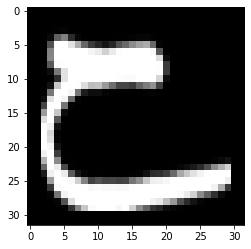

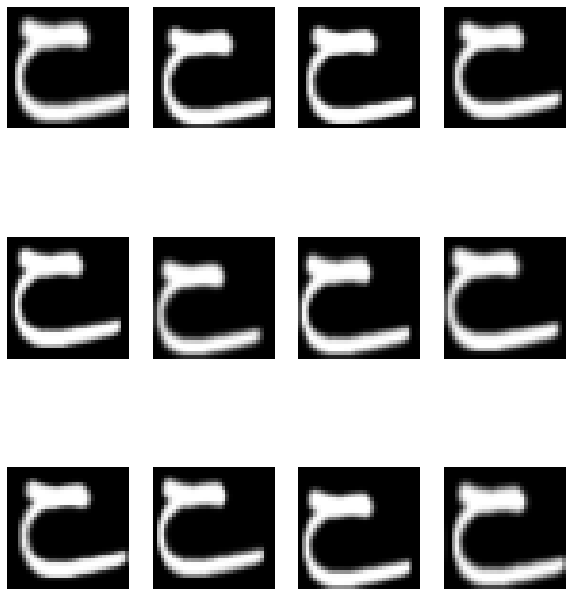

In [16]:
rows = 3
columns = 4
for images, _ in train_dataset.take(1):
    plt.imshow(tf.squeeze(images[0]), cmap='gray', vmin=0, vmax=255)
    fig = plt.figure(figsize=(10, 12))
    for i in range(12):
        with tf.device('/CPU:0'):
            augmented_images = data_augmentation_layers(images)
        fig.add_subplot(rows, columns, i + 1)
        # plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.imshow(tf.squeeze(augmented_images[0]), cmap='gray', vmin=0, vmax=255)
        plt.axis("off")

### Creating the Model

First, we'll add the `data_augmentation_layers` and the `normalization_layer`, following which we'll create a convolutional neural network.

Learn more about CNNs here: <https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/>

In [17]:
model = keras.Sequential(
    [
        data_augmentation_layers,
        normalization_layer,
        layers.Conv2D(32, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Conv2D(64, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Dropout(DROPOUT),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

### Compiling and Building Model
Note that we are using Categorical Crossentropy as the loss function, and this is well suited for categorical output data.
Read more here: <https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression>

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 32, 32, 1)           0         
_________________________________________________________________
rescaling (Rescaling)        (32, 32, 32, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (32, 30, 30, 32)          320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 15, 15, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 13, 13, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 6, 6, 64)            0         
_________________________________________________________________
dropout (Dropout)            (32, 6, 6, 64)           

In [19]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


479/479 [==============================] - 14s 27ms/step - loss: 0.3417 - accuracy: 0.8871 - val_loss: 0.0574 - val_accuracy: 0.9829
Epoch 2/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0956 - accuracy: 0.9699 - val_loss: 0.0426 - val_accuracy: 0.9882
Epoch 3/15
479/479 [==============================] - 11s 22ms/step - loss: 0.0665 - accuracy: 0.9797 - val_loss: 0.0259 - val_accuracy: 0.9894
Epoch 4/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0480 - accuracy: 0.9865 - val_loss: 0.0215 - val_accuracy: 0.9906
Epoch 5/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.0192 - val_accuracy: 0.9941
Epoch 6/15
479/479 [==============================] - 11s 23ms/step - loss: 0.0344 - accuracy: 0.9890 - val_loss: 0.0244 - val_accuracy: 0.9912
Epoch 7/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0184 - val_accuracy: 0.9935
Epo

### Measuring Performance on Training and Test Data

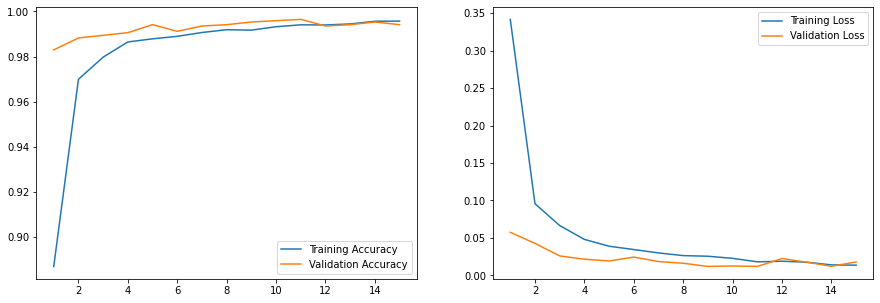

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
sns.lineplot(x=epochs_range, y=acc, legend='brief', label='Training Accuracy')
sns.lineplot(x=epochs_range, y=val_acc, legend='brief', label='Validation Accuracy')

fig.add_subplot(1, 2, 2)
sns.lineplot(x=epochs_range, y=loss, legend='brief', label='Training Loss')
sns.lineplot(x=epochs_range, y=val_loss, legend='brief', label='Validation Loss')
plt.show()

### Metrics

| Data       | Accuracy | Loss   |
|:-----------|:--------:|-------:|
| Training   | 99.52%   | 0.0139 |
| Validation | 99.65%   | 0.0107 |

<!-- Training Accuracy: 99.52%

Validation Accuracy: 99.65%

Training Loss: 0.0139

Validation Loss: 0.0107 -->


We can see that the model's accuracy and validation accuracy quickly went up during and after the first epoch and then it saturated around epoch #10. 

Training and validation loss also fell dramatically after the second epoch, and reached a saturation around epoch #11.

In [22]:
print("Evaluate")
result = model.evaluate(test_dataset)
result = dict(zip(model.metrics_names, result))

Evaluate
94/94 [==============================] - 1s 11ms/step - loss: 0.0215 - accuracy: 0.9953
